<a href="https://colab.research.google.com/github/Yohk2291/MachineLearning/blob/master/image_classification/CNN2_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KerasでCNNを実装 2


ライブラリのインポート

In [0]:
# numpy
import numpy as np

# kerasから必要なライブラリをimport
from keras import utils
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import plot_model



# 描画に使うライブラリ
import matplotlib.pyplot as plt

Cifer10のロードと可視化

In [0]:
# データのロード
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
# ラベルとクラス数の定義
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])
n_classes = 10

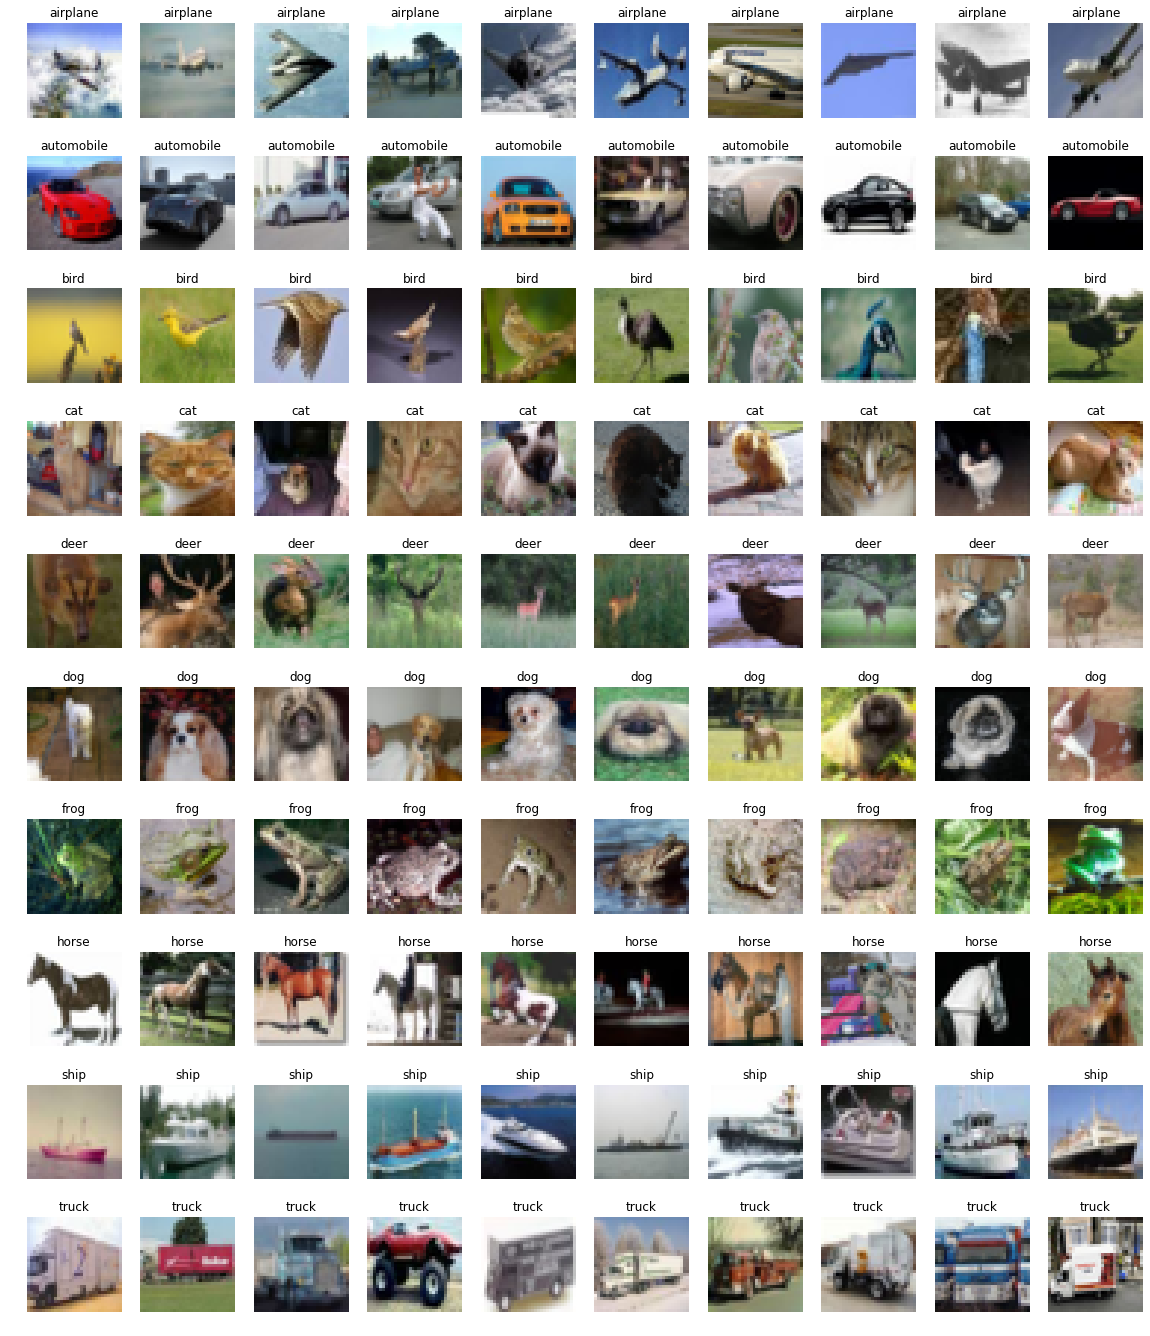

In [0]:
pos = 1
plt.figure(figsize=(20,24))

# 各クラスごとにプロット
for targetClass in range(n_classes):
    targetIdx = []
    # クラスclassIDの画像のインデックスリストを取得
    for i in range(len(y_train)):
        if y_train[i][0] == targetClass:
            targetIdx.append(i)

    # 各クラスからランダムに選んだ最初の10個の画像を描画
    np.random.shuffle(targetIdx)
    for idx in targetIdx[:10]:
        plt.subplot(10, 10, pos)
        plt.imshow(X_train[idx])
        plt.axis('off')
        plt.title(cifar10_labels[y_train[idx][0]])
        pos += 1
plt.show()

In [0]:
# 入力画像の前処理（正規化）
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 出力ラベルの前処理（カテゴリカル変数化）
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

バッチサイズ500、エポック数150（以下共通）

In [0]:
# 学習パラメータの定義
batch_size = 500
epochs = 150
steps_per_epoch = X_train.shape[0] // batch_size
validation_steps = X_test.shape[0] // batch_size


## CNNの実装(4) 学習率逓減(ReduceLROnPlateau)

In [0]:
# CNNモデルの定義(model3と同一)
model4 = Sequential()

model4.add(Conv2D(64, (3,3),  padding='same', input_shape=(32, 32, 3), activation='relu')) 
model4.add(Conv2D(64, (3,3), padding='same', activation='relu')) 

model4.add(BatchNormalization()) # Batch Normalizationを使う
model4.add(Conv2D(64, (3,3), padding='same', activation='relu')) 
model4.add(MaxPool2D(pool_size=(2,2)))
model4.add(Dropout(0.5))


model4.add(Conv2D(128, (3,3), padding='same', activation='relu')) 
model4.add(Conv2D(128, (3,3), padding='same', activation='relu')) 

model4.add(BatchNormalization()) 
model4.add(Conv2D(128, (3,3), padding='same', activation='relu')) 
model4.add(MaxPool2D(pool_size=(2,2)))
model4.add(Dropout(0.5))


model4.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model4.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model4.add(BatchNormalization()) 

model4.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model4.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model4.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model4.add(BatchNormalization()) 

model4.add(Conv2D(512, (3,3), padding='same', activation='relu')) 
model4.add(Conv2D(512, (3,3), padding='same', activation='relu'))  
model4.add(GlobalAveragePooling2D())


model4.add(Dense(1024, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1024, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(n_classes, activation='softmax'))


model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)      

In [0]:
model4.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
train_gen_new = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.2, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        channel_shift_range = 0.2,
        horizontal_flip=True,  
        vertical_flip=False).flow(X_train,y_train, batch_size )


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0002)

In [0]:
# 学習
val_gen = ImageDataGenerator().flow(X_test, y_test, batch_size)
history = model4.fit_generator(train_gen_new, epochs=epochs, steps_per_epoch = steps_per_epoch,\
                          validation_data = val_gen, validation_steps =validation_steps, callbacks=[learning_rate_reduction])

score = model4.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/150
100/100 [==============================] - 57s 574ms/step - loss: 0.2145 - acc: 0.9252 - val_loss: 0.3407 - val_acc: 0.9030
Epoch 2/150
100/100 [==============================] - 57s 565ms/step - loss: 0.2168 - acc: 0.9248 - val_loss: 0.3157 - val_acc: 0.9081
Epoch 3/150
100/100 [==============================] - 57s 565ms/step - loss: 0.2141 - acc: 0.9261 - val_loss: 0.3225 - val_acc: 0.9084
Epoch 4/150
100/100 [==============================] - 57s 565ms/step - loss: 0.2158 - acc: 0.9257 - val_loss: 0.3075 - val_acc: 0.9106
Epoch 5/150
100/100 [==============================] - 56s 565ms/step - loss: 0.2123 - acc: 0.9258 - val_loss: 0.3168 - val_acc: 0.9103
Epoch 6/150
100/100 [==============================] - 57s 566ms/step - loss: 0.2112 - acc: 0.9277 - val_loss: 0.3488 - val_acc: 0.8999
Epoch 7/150
100/100 [==============================] - 57s 565ms/step - loss: 0.2124 - acc: 0.9259 - val_loss: 0.3563 - val_acc: 0.8987
Epoch 8/150
100/100 [===========================

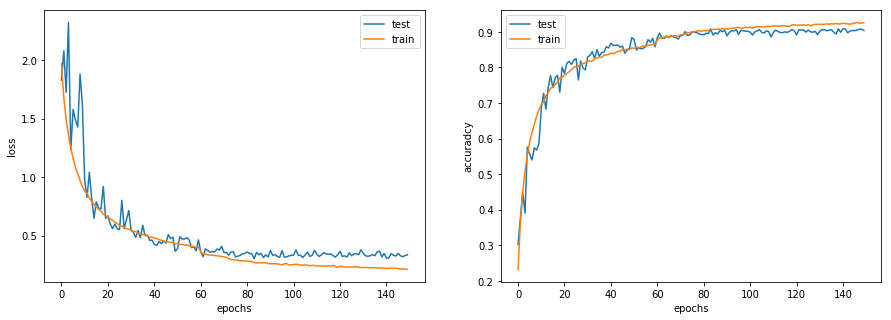

In [0]:
# 各epochののコストと精度をプロット
fig = plt.figure(figsize=(15,5))

# コストのプロット
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# 精度のプロット
plt.subplot(1,2,2)
plt.plot(history.history['val_acc'], label='test')
plt.plot(history.history['acc'], label='train')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuradcy')

plt.show()

## CNNの実装(5) 学習率逓減(指定のエポック数毎に段階的に)

In [0]:
# CNNモデルの定義(model3と同一)
model5 = Sequential()

model5.add(Conv2D(64, (3,3),  padding='same', input_shape=(32, 32, 3), activation='relu')) 
model5.add(Conv2D(64, (3,3), padding='same', activation='relu')) 

model5.add(BatchNormalization()) # Batch Normalizationを使う
model5.add(Conv2D(64, (3,3), padding='same', activation='relu')) 
model5.add(MaxPool2D(pool_size=(2,2)))
model5.add(Dropout(0.5))


model5.add(Conv2D(128, (3,3), padding='same', activation='relu')) 
model5.add(Conv2D(128, (3,3), padding='same', activation='relu')) 

model5.add(BatchNormalization()) 
model5.add(Conv2D(128, (3,3), padding='same', activation='relu')) 
model5.add(MaxPool2D(pool_size=(2,2)))
model5.add(Dropout(0.5))


model5.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model5.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model5.add(BatchNormalization()) 

model5.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model5.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model5.add(Conv2D(256, (3,3), padding='same', activation='relu')) 
model5.add(BatchNormalization()) 

model5.add(Conv2D(512, (3,3), padding='same', activation='relu')) 
model5.add(Conv2D(512, (3,3), padding='same', activation='relu'))  
model5.add(GlobalAveragePooling2D())


model5.add(Dense(1024, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1024, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(n_classes, activation='softmax'))


model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 128)      

In [0]:
model5.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
def step_decay(epoch):
    lr = 0.001
    if(epoch >= 100):
        lr/=5
    if(epoch>=140):
        lr/=2
    return lr

In [0]:
# 学習
val_gen = ImageDataGenerator().flow(X_test, y_test, batch_size)
lr_decay = LearningRateScheduler(step_decay)
history = model5.fit_generator(train_gen_new, epochs=epochs, steps_per_epoch = steps_per_epoch,\
                          validation_data = val_gen, validation_steps =validation_steps, callbacks=[lr_decay])

score = model5.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/150
100/100 [==============================] - 62s 621ms/step - loss: 2.0362 - acc: 0.1943 - val_loss: 4.7358 - val_acc: 0.1921
Epoch 2/150
100/100 [==============================] - 57s 568ms/step - loss: 1.7260 - acc: 0.3265 - val_loss: 2.4639 - val_acc: 0.3079
Epoch 3/150
100/100 [==============================] - 57s 570ms/step - loss: 1.5266 - acc: 0.4286 - val_loss: 3.3981 - val_acc: 0.3136
Epoch 4/150
100/100 [==============================] - 57s 567ms/step - loss: 1.3740 - acc: 0.5027 - val_loss: 1.6946 - val_acc: 0.5123
Epoch 5/150
100/100 [==============================] - 57s 568ms/step - loss: 1.2450 - acc: 0.5537 - val_loss: 1.3508 - val_acc: 0.5894
Epoch 6/150
100/100 [==============================] - 57s 567ms/step - loss: 1.1655 - acc: 0.5870 - val_loss: 1.7006 - val_acc: 0.5320
Epoch 7/150
100/100 [==============================] - 57s 569ms/step - loss: 1.0757 - acc: 0.6195 - val_loss: 1.5084 - val_acc: 0.5730
Epoch 8/150
100/100 [===========================

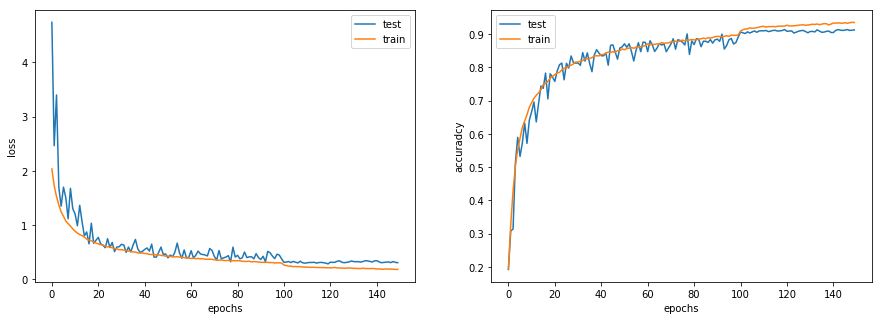

In [0]:
# 各epochののコストと精度をプロット
fig = plt.figure(figsize=(15,5))

# コストのプロット
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# 精度のプロット
plt.subplot(1,2,2)
plt.plot(history.history['val_acc'], label='test')
plt.plot(history.history['acc'], label='train')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuradcy')

plt.show()